In [61]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

os.getcwd() #check current working directory

/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/train.csv


'/kaggle/working'

In [62]:
#install impyute to replace missing values (if not already installed)
try:
    import impyute
except ImportError as e:
    !pip install impyute # module doesn't exist, deal with it.
    
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import scipy.stats as scp

**LOAD & CHECK DATA**

In [63]:
#load data

# Read the data
train_data = pd.read_csv('../input/titanic/train.csv', index_col='PassengerId')
X_test_full = pd.read_csv('../input/titanic/test.csv', index_col='PassengerId')

#X.head()
y = train_data['Survived']
X = train_data.drop('Survived', axis=1)

#print(list(X.columns))

#print(y.head())
#print(X.head())


In [64]:
#check missing values
print(' Training set: count of missing values')
print(X.isna().sum())
print('\n Testing set: count of missing values')
print(X_test_full.isna().sum())

 Training set: count of missing values
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

 Testing set: count of missing values
Pclass        0
Name          0
Sex           0
Age          86
SibSp         0
Parch         0
Ticket        0
Fare          1
Cabin       327
Embarked      0
dtype: int64


**PREPROCESSING**

/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


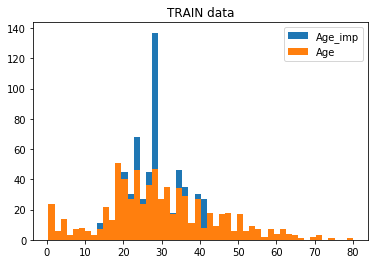

In [65]:
from impyute.imputation.cs import mice
import matplotlib.pyplot as plt

#replace missing values for numeric TRAIN data
X_num_data = X._get_numeric_data()
X_obj_data = X.select_dtypes(include='object') #save separately

# start the MICE training 
X_num_data_imp = pd.DataFrame(mice(X_num_data.values))
X_num_data_imp.columns = X_num_data.columns
X_num_data_imp.index = X_num_data.index

#Since Age values cannot be <0, replace with an Age value of passenger with the closest Fare value
if not X_num_data_imp.Age[X_num_data_imp.Age < 0].empty: #if there are negative Age values
    #find modal fare of passengers with negative Age
    FX = X_num_data_imp.Fare[X_num_data_imp.Age < 0]
    mX = scp.mode(FX)
    mX = float(mX[0])

    #find closest fare values
    F = np.sort(X_num_data_imp.Fare.unique())
    neg_ind = np.where(F == mX)
    neg_ind = int(neg_ind[0])

    #replace with modal Age values based on closest fare values
    if(abs(F[neg_ind - 1] - F[neg_ind]) < abs(F[neg_ind + 1] - F[neg_ind])):
        FA = X_num_data_imp.Age[X_num_data_imp.Fare == F[neg_ind - 1]]
    else:
        FA = X_num_data_imp.Age[X_num_data_imp.Fare == F[neg_ind + 1]]

    mA = scp.mode(FA)
    mA = float(mA[0])
    X_num_data_imp.Age[X_num_data_imp.Age < 0] = mA


# visual check that distribution has passing resemblance
%matplotlib inline

plt.figure(1)
plt.hist(X_num_data_imp.Age,bins=50,label='Age_imp')
plt.hist(X.Age,bins=50,label='Age')
plt.legend()
plt.title('TRAIN data')

#combine back into 1 dataframe
X_imp =  pd.concat([X_num_data_imp,X_obj_data],axis=1)

In [ ]:
#replace missing values for numeric TEST data
X_test_num_data = X_test_full._get_numeric_data()
X_test_obj_data = X_test_full.select_dtypes(include='object') #save separately

# start the MICE training 
X_test_num_data_imp = pd.DataFrame(mice(X_test_num_data.values))
X_test_num_data_imp.columns = X_test_num_data.columns
X_test_num_data_imp.index = X_test_num_data.index

#Since Age values cannot be <0, replace with an Age value of passenger with the closest Fare value
if not X_test_num_data_imp.Age[X_test_num_data_imp.Age < 0].empty: #if there are negative Age values
    #find modal fare of passengers with negative Age
    FX = X_test_num_data_imp.Fare[X_test_num_data_imp.Age < 0]
    mX = scp.mode(FX)
    mX = float(mX[0])

    #find closest fare values
    F = np.sort(X_test_num_data_imp.Fare.unique())
    neg_ind = np.where(F == mX)
    neg_ind = int(neg_ind[0])

    #replace with modal Age values based on closest fare values
    if(abs(F[neg_ind - 1] - F[neg_ind]) < abs(F[neg_ind + 1] - F[neg_ind])):
        FA = X_test_num_data_imp.Age[X_test_num_data_imp.Fare == F[neg_ind - 1]]
    else:
        FA = X_test_num_data_imp.Age[X_test_num_data_imp.Fare == F[neg_ind + 1]]

    mA = scp.mode(FA)
    mA = float(mA[0])
    X_test_num_data_imp.Age[X_test_num_data_imp.Age < 0] = mA

# visual check that distribution has passing resemblance
%matplotlib inline

plt.figure(1)
plt.hist(X_test_num_data_imp.Age,bins=50,label='Age_imp')
plt.hist(X_test_full.Age,bins=50,label='Age')
plt.legend()
plt.title('TEST data')

#combine back into 1 dataframe
X_test_full_imp =  pd.concat([X_test_num_data_imp,X_test_obj_data],axis=1)

In [ ]:
#create new feature - Title 
#credit to https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data/
def substrings_in_string(big_string, substrings):
    for substring in substrings:
        if str.find(big_string, substring) != -1:
            return substring
    print(big_string)
    return np.nan

#assign title
title_list=['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev',
                    'Dr', 'Ms', 'Mlle','Col', 'Capt', 'Mme', 'Countess',
                    'Don', 'Jonkheer']

X_imp['Title']=X_imp['Name'].map(lambda x: substrings_in_string(x, title_list))

#replacing all titles with mr_hon, mrs_hon, mr, mrs, miss, master
def replace_titles(x):
    title=x['Title']
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
        return 'Mr_Hon'
    elif title in ['Countess', 'Mme']:
        return 'Mrs_Hon'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title
    
X_imp['Title']=X_imp.apply(replace_titles, axis=1)

    
#replace the 2 missing Embarked values in training set with modal value
X_imp['Embarked'].fillna(X_imp['Embarked'].mode()[0], inplace = True)


#do the same for test data
X_test_full_imp['Title']=X_test_full_imp['Name'].map(lambda x: substrings_in_string(x, title_list))
X_test_full_imp['Title']=X_test_full_imp.apply(replace_titles, axis=1)

In [ ]:
#create new feature - relatives
X_imp['Relatives']=X_imp['SibSp']+X_imp['Parch']

#do the same for test data
X_test_full_imp['Relatives']=X_test_full_imp['SibSp']+X_test_full_imp['Parch']

#select relevant features
num_features = ['Pclass', 'Age', 'Fare', 'Relatives']
obj_features = ['Sex','Embarked', 'Title']

X_working = pd.concat([X_imp[num_features],
                             pd.get_dummies(X_imp.Sex,prefix='Sex'),
                             pd.get_dummies(X_imp.Embarked,prefix='Embarked'),
                             pd.get_dummies(X_imp.Title,prefix='Title')],axis=1)     

X_test_working = pd.concat([X_test_full_imp[num_features],
                             pd.get_dummies(X_test_full_imp.Sex,prefix='Sex'),
                             pd.get_dummies(X_test_full_imp.Embarked,prefix='Embarked'),
                             pd.get_dummies(X_test_full_imp.Title,prefix='Title')],axis=1)  

In [ ]:
#check for mismatched columns
print(list(X_working.columns))
print(list(X_test_working.columns))

In [ ]:
#test set doesn't have aristocrat female (to automate in future)
X_test_working['Title_Mrs_Hon']=0

#check that features match
print(list(X_test_working.columns))

In [ ]:
#check
X_test_working.head()

**MODEL & PREDICT**

try 2 - train/test split

In [ ]:
from sklearn.metrics import accuracy_score

for i in range(5):
    X_train, X_valid, y_train, y_valid = train_test_split(X_working, y, train_size=0.8, test_size=0.2)

    my_model = XGBClassifier(objective='binary:logistic',n_estimators=500,learning_rate=0.05,
                             verbosity=0, max_depth=5)

    my_model.fit(X_train, y_train, 
                 early_stopping_rounds=20, 
                 eval_set=[(X_valid, y_valid)],
                 verbose=False) # Your code here

    predictions = my_model.predict(X_valid)

    print(accuracy_score(y_valid,predictions))

predictions = my_model.predict(X_test_working)
print('\ncompleted predictions for test set')

**WRITE OUTPUT FILE**

In [ ]:
#write output for competition

from datetime import datetime

#get date for filename
now = datetime.now() # current date and time
date = now.strftime("%d%m%Y")
#print("date",date)

output = pd.DataFrame({'PassengerId': X_test_working.index, 'Survived': predictions})
output.to_csv('submission_XK_'+date+'.csv', index=False)
#print("Your submission was successfully saved!")
print(predictions)

**MISC/TESTING**

In [ ]:
X_working.Fare

my_model = XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=4)
my_model.fit(X_train, y_train, 
             early_stopping_rounds=5, 
             eval_set=[(X_valid, y_valid)], 
             verbose=False)

women = train_data.loc[train_data.Sex == 'female']["Survived"]
rate_women = sum(women)/len(women)

print("% of women who survived:", rate_women)

men = train_data.loc[train_data.Sex == 'male']["Survived"]
rate_men = sum(men)/len(men)

print("% of men who survived:", rate_men)

CHECK ACC OF BASIC MODEL

##Basic RFR model

from sklearn.ensemble import RandomForestClassifier

train_data = pd.read_csv('../input/titanic/train.csv', index_col='PassengerId')
test_data = pd.read_csv('../input/titanic/test.csv', index_col='PassengerId')

y = train_data["Survived"]
features = ["Pclass", "Sex", "SibSp", "Parch"]
X = pd.get_dummies(train_data[features])
X_test = pd.get_dummies(test_data[features])

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
scores = cross_val_score(model, X, y, cv=10,scoring='accuracy')
print(scores.mean())

#model.fit(X_working, y)
#predictions = model.predict(X_test_working)

#output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
#output.to_csv('my_submission.csv', index=False)
#print("Your submission was successfully saved!")
#print(predictions)